<a href="https://colab.research.google.com/github/jproctor-rebecca/lambdaprojects/blob/master/Spotify_recommender_NN_explore_RJProctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and enviroment setup

In [16]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.manifold import TSNE


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# random state
rs = 42

## Load and clean data

In [4]:
# load data
# URL = 'https://github.com/Build-Week-Track-Team-7/explore/blob/main/data.csv.zip?raw=true'

# path_to_zip = tf.keras.utils.get_file('./data.zip', origin=URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

df_raw = pd.read_csv('./data.csv')
df_raw.head()


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"FantasiestÃ¼cke, Op. 111: PiÃ¹ tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn GoszczyÅ„ski'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,9/25/1928,0.0926,108.003,0.7200,1928
4,0.990,"['FrÃ©dÃ©ric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [6]:
    
def clean_data(df):
  '''
  a functions that drops columns which either 
  add bias or noise to dataset 

  raw text data
  ---
  input - dataframe object/ndarray
  output - dataframe object/ndarray
  '''
  # bias
  df_cleaned = df.drop('artists', axis=1)
    # duplicate/triplicate information may disproportantly weight results
  df_cleaned = df_cleaned.drop('release_date', axis=1)
    # duplicate/triplicate information may disproportantly weight results

  # noise
  df_cleaned = df_cleaned.drop('id', axis=1)
    # has no meaningful contribution to results

  return df_cleaned


data_cleaned = clean_data(df_raw)
print(data_cleaned.shape)
data_cleaned.head()

(169909, 16)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.995,0.708,158648,0.1950,0,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,0.0506,118.469,0.7790,1928
1,0.994,0.379,282133,0.0135,0,0.901,8,0.0763,-28.454,1,"FantasiestÃ¼cke, Op. 111: PiÃ¹ tosto lento",0,0.0462,83.972,0.0767,1928
2,0.604,0.749,104300,0.2200,0,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,0.9290,107.177,0.8800,1928
3,0.995,0.781,180760,0.1300,0,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,0.0926,108.003,0.7200,1928
4,0.990,0.210,687733,0.2040,0,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,0.0424,62.149,0.0693,1928


In [17]:
# shuffle dataset to avoid bias
num_rows = 169909
data_cleaned = data_cleaned.sample(n=num_rows, 
                                   replace=False,
                                   random_state=rs
                                   )

# reindex 
data_cleaned = data_cleaned.reset_index(drop=True)


In [18]:
data_cleaned.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.0343,0.479,204507,0.7100,0,0.000036,2,0.1120,-10.331,1,Fireplace,31,0.0369,101.607,0.5970,1987
1,0.4890,0.728,201973,0.7140,0,0.000011,10,0.0912,-7.918,1,The Dry Cleaner From Des Moines,32,0.1520,89.736,0.9120,1979
2,0.9550,0.777,169920,0.5080,0,0.897000,8,0.1150,-11.817,1,The New Birmingham Breakdown,7,0.0887,113.200,0.9620,1938
3,0.6070,0.816,191907,0.3750,0,0.000009,7,0.0933,-8.053,1,Banana Pancakes,70,0.0996,114.303,0.6150,2005
4,0.9470,0.116,592813,0.0653,0,0.151000,10,0.1630,-25.633,1,Das Lied von der Erde: II. Der Einsame im Herbst,0,0.0495,170.923,0.0375,1945


#### EDA

In [19]:
data_cleaned.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,5.200519,0.206690,-11.370289,0.708556,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,3.515257,0.176796,5.666765,0.454429,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,2.000000,0.098400,-14.470000,0.000000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,5.000000,0.135000,-10.474000,1.000000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,8.000000,0.263000,-7.118000,1.000000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.969000,244.091000,1.000000,2020.000000


In [20]:
data_cleaned.describe(exclude='number')

,name
count,169909
unique,132939
top,Summertime
freq,62


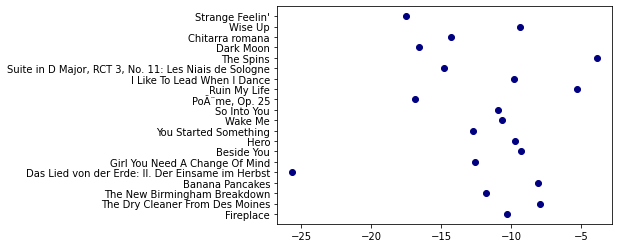

In [38]:
# scatter plot of features as they relate to sampling of individual songs
# features within the -25 to 0 range
plt.scatter(data_cleaned['loudness'][:20], data_cleaned['name'][:20], c='navy')
plt.show()


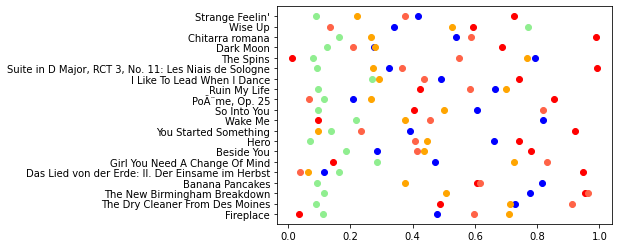

In [47]:
# features within the 0-1 range
plt.scatter(data_cleaned['acousticness'][:20], data_cleaned['name'][:20], c='red')
plt.scatter(data_cleaned['danceability'][:20], data_cleaned['name'][:20], c='blue')
plt.scatter(data_cleaned['energy'][:20], data_cleaned['name'][:20], c='orange')
plt.scatter(data_cleaned['liveness'][:20], data_cleaned['name'][:20], c='lightgreen')
plt.scatter(data_cleaned['valence'][:20], data_cleaned['name'][:20], c='tomato')

plt.show()

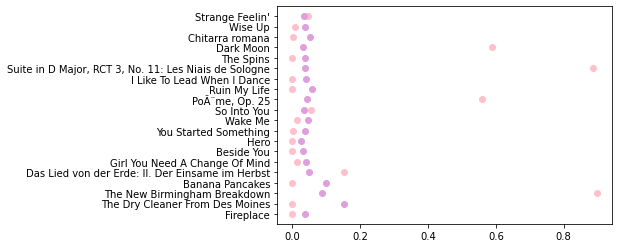

In [34]:
# features that may have some correlation
plt.scatter(data_cleaned['instrumentalness'][:20], data_cleaned['name'][:20], c='pink')
plt.scatter(data_cleaned['speechiness'][:20], data_cleaned['name'][:20], c='plum')
plt.show()

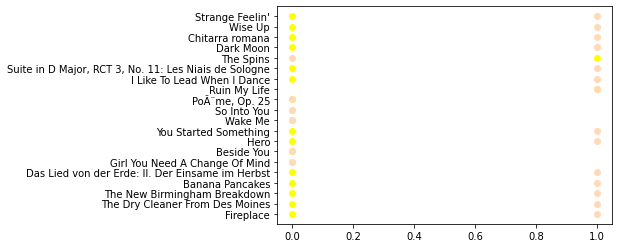

In [32]:
# boolean values
plt.scatter(data_cleaned['explicit'][:20], data_cleaned['name'][:20], c='yellow')
plt.scatter(data_cleaned['mode'][:20], data_cleaned['name'][:20], c='peachpuff')
plt.show()

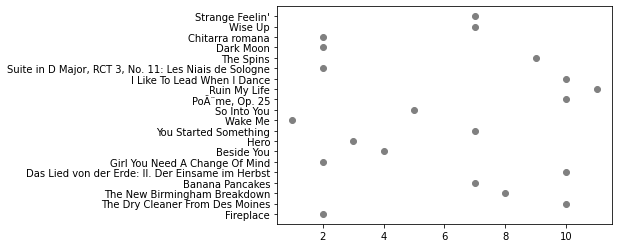

In [37]:
# features within the 1 - 11 range
plt.scatter(data_cleaned['key'][:20], data_cleaned['name'][:20], c='gray')
plt.show()

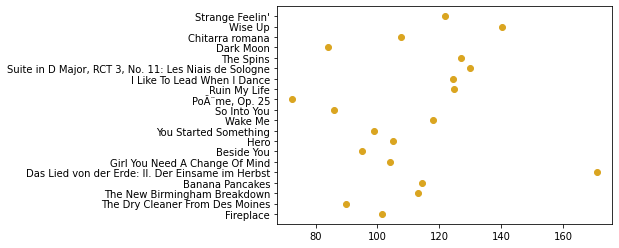

In [39]:
# features within the 70 - 170 range
plt.scatter(data_cleaned['tempo'][:20], data_cleaned['name'][:20], c='goldenrod')
plt.show()

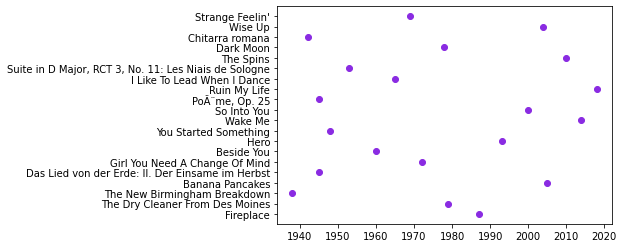

In [46]:
# features within years 1921 - 2020 
plt.scatter(data_cleaned['year'][:20], data_cleaned['name'][:20], c='blueviolet')
plt.show()

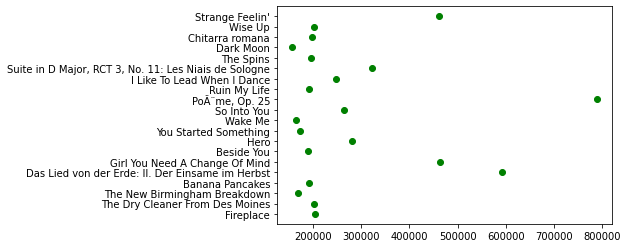

In [36]:
# features within the 200000 - 800000 range
plt.scatter(data_cleaned['duration_ms'][:20], data_cleaned['name'][:20], c='green')
plt.show()

## Additional preproccessing of data
Pipeline 1 - (instantiate, fit_transform)


*   StandardScaler

Pipeline 2, 3, 4 - (instantiate, fit, predict)

*   NN
*   PCA
*   t_SNE

#### Pipeline 1

In [9]:
# create feature matrix
X = data_cleaned.drop('name', axis=1)
y = data_cleaned['name']



In [ ]:
## TODO..create transformer functions outside of pipeline, get working and  then move inside pipeline


# normalize standardize data using pipeline (instantiate, fit, transform)
# onehotender, ordinal encoder, standard scaler in order

# instantiate pipeline
pipe_1 = Pipeline([
                 #('onehotencoder', OneHotEncoder()), 
                 #('ordinalencoder', OrdinalEncoder()), 
                 ('standardscaler', StandardScaler()), 
                 ])

# fit data to transformer and transform data
pipe_1.fit_transform(X, y)


# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


In [ ]:


# split data - train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42
                                                    )

# X_arr = np.asarray(X)
# y_arr = np.asarray(y)


# # split data - train/test split
# X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, 
#                                                     test_size=0.20, 
#                                                     random_state=42
#                                                     )


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### Pipeline 2

#### Pipeline 3

#### Pipeline 4

#### Transform data to numpy array to feed into NN

In [ ]:
# transform data to np array


## Neural Network model 
Pipeline 1 - (instantiate, compile, fit)

*   RNN
*   LSTM
*   RNN (deep and wide)

## Evaluate model

## Vizualize results

## Conclusions

## Export to application

In [ ]:
# convert to json
